In [1]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.document_loaders import PyPDFium2Loader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import SentenceTransformersTokenTextSplitter 
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from langchain.callbacks import StdOutCallbackHandler
from transformers import AutoTokenizer, TextStreamer, pipeline
import matplotlib.pyplot as plt

/home/aleksander/projects/phi_train/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the model and tokenizer
model = AutoModelForCausalLM.from_pretrained("alekswael/phipaca_instruction", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("alekswael/phipaca_instruction", trust_remote_code=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/aleksander/projects/phi_train/venv/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


/home/aleksander/projects/phi_train/venv/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so: undefined symbol: cadam32bit_grad_fp32


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


PhiForCausalLM(
  (transformer): PhiModel(
    (embd): Embedding(
      (wte): Embedding(51200, 2048)
      (drop): Dropout(p=0.0, inplace=False)
    )
    (h): ModuleList(
      (0-23): 24 x ParallelBlock(
        (ln): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (resid_dropout): Dropout(p=0.0, inplace=False)
        (mixer): MHA(
          (rotary_emb): RotaryEmbedding()
          (Wqkv): lora.Linear(
            (base_layer): Linear(in_features=2048, out_features=6144, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=2048, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=6144, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
          )
          (out_proj):

In [3]:
# LOAD EMBEDDINGS MODEL

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/paraphrase-MiniLM-L6-v2", model_kwargs={"device": DEVICE})

embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


In [4]:
#loader = PyPDFLoader("data/Mao_HHAI_2023.pdf")
loader = PyPDFium2Loader("../data/Mao_HHAI_2023.pdf")

# pages = loader.load_and_split()

# pages[0]

document = loader.load()

In [5]:
# text_splitter = RecursiveCharacterTextSplitter(
#     chunk_size=500,
#     chunk_overlap=0,
#     separators=["\n\n", "\n", " ", ""]
#     )

text_splitter = CharacterTextSplitter(
    separator = "\n",
    chunk_size = 500,
    chunk_overlap = 20,
    length_function = len,
    is_separator_regex = False,
)

texts = text_splitter.split_documents(document)

len(texts)

125

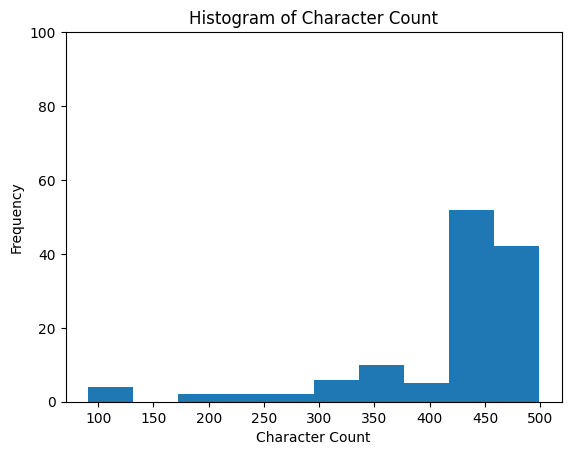

In [8]:
# Histogram of the character counts per chunk

char_data = []

for x in texts:
    char_count = len(x.page_content)

    char_data.append(char_count)

plt.hist(char_data)
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.title('Histogram of Character Count')
plt.ylim(0, 100)
plt.show()


In [6]:
%%time
# Upload the embeddings to the vector store

db = Chroma.from_documents(texts, embeddings) #, persist_directory="db"

CPU times: user 3min 12s, sys: 6.99 s, total: 3min 19s
Wall time: 50.5 s


In [7]:
streamer = TextStreamer(tokenizer, skip_prompt=False, skip_special_tokens=False)
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    do_sample=False,
    #top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)


In [8]:
cllm = HuggingFacePipeline(pipeline=text_pipeline)

In [9]:
template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n
Instruction: Use the following pieces of context to answer the question at the end.\n
----------------\n
{context}\n
Input: {question}\n
Response: 
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

In [12]:
qa_chain = RetrievalQA.from_chain_type(
    llm=cllm,
    chain_type="stuff",
    retriever=db.as_retriever(search_type="similarity", search_kwargs={"k": 5}),
    return_source_documents=False,
    chain_type_kwargs={"prompt": prompt},
    verbose=True
)

In [19]:
tokenizer_2 = AutoTokenizer.from_pretrained("sentence-transformers/paraphrase-MiniLM-L6-v2", trust_remote_code=True)

tokens = tokenizer_2.tokenize("""    RESEARCH REPORT
A scientific creativity test for secondary school
students
Weiping Hu, Shanxi Teachers’ University, China and Philip Adey, King’s College London, UK
This study describes the development of a test of scientific creativity for use with secondary school
students. A Scientific Creativity Structure Model (SCSM) was constructed on the basis of an analysis of
meanings and aspects of scientific creativity found in the literature. 50 science teachers in China took
part in an initial evaluation of this model. On the basis of their analyses and comments, and drawing on
the experience of the Torrance Tests of Creative Thinking, a 7-item scale for measuring scientific
creativity of secondary school students was developed and validated through analyses of item response data of 160 secondary school students in England. Item analyses were conducted to check on item
discrimination, internal consistency, agreement between scorers, construct-related validity, and face validity. Analysis showed adequate reliabilities and validities. As an example of how the test might be
used, data from the pilot use of the test were used to investigate the relative scientific creativity of
students of different age and ability level. The results indicated that for this trial sample, the scientific
creativity of secondary school students increases with increase in age, and science ability is a necessary
but not sufficient condition for scientific creativity. Further work is also suggested.
Introduction why scientific creativity?
This paper will describe the development of a test of scientific creativity. It may
immediately be asked why another test of such creativity is required, since over 100 creativity tests have already been reported in the literature. The answer lies in
the specific needs of scientific creativity. Firstly, ‘doing science’ is far more than
either mastering an existing body of knowledge or of following set procedures. Almost by definition scientific research requires creativity in the sense of going
beyond existing knowledge and techniques, of creating new understandings. But even at a more mundane level, solving problems in science requires a student to
explore his or her repertoire, to imagine a variety of routes to a solution, and
frequently to create novel combinations of knowledge or novel techniques for a
solution. This is the justification for considering scientific creativity as worthy of
attention in the education of students who will either become scientists or who need an understanding of the way that scientists work as part of their general
understanding of society. Although there is some research about scientific crea￾tivity of scientists, few reports about scientific creativity of secondary students have been found. If scientific creativity is to be an important element in secondary
education, then it becomes useful to have an instrument for assessing levels of
scientific creativity which could be used for formative or summative purposes. Progress in scientific research depends on the availability of the necessary
International Journal of Science Education ISSN 0950–0693 print/ISSN 1464–5289 online # 2002 Taylor & Francis Ltd
http://www.tandf.co.uk/journals
DOI: 10.1080/09500690110098912
INT. J. SCI. EDUC., 2002, VOL. 24, NO. 4, 389–403""")

len(tokens)

config.json: 100%|██████████| 629/629 [00:00<00:00, 2.98MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 1.41MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 2.33MB/s]
special_tokens_map.json: 100%|██████████| 112/112 [00:00<00:00, 194kB/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors


614

In [13]:
# result = qa_chain("What affects whether AI is accepted as a technology?")

handler = StdOutCallbackHandler()
qa_chain.run("What affects whether AI is accepted as a technology?", callbacks=[handler])



> Entering new RetrievalQA chain...


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

Instruction: Use the following pieces of context to answer the question at the end.

----------------

Figure 1. HI-TAM: Hybrid Intelligence Technology Acceptance Model adapted from the AI-TAM [21] incor￾porating key aspects from HI including AI transparency and user control, in order to support both virtual assis￾tant training and general human-AI mutual learning. Qualitative co-occurrences and quantitative correlations
were based on N=8.
3. Methods

understand factors influencing technology acceptance, including the widely used Tech￾nology Acceptance Model (TAM) which links user acceptance of technology to per￾ceived usefulness and ease of use [20]. The TAM has been applied to various c

"The perception of how AI will affect jobs can greatly influence its acceptance by users. Factors such as perceived benefits like increased efficiency and accuracy are important considerations when evaluating if someone would accept AI technologies. Additionally, concerns about potential job displacement should also be taken into account since people may feel threatened by machines replacing them. It's crucial to address any fears regarding privacy issues and ensure proper security measures are implemented before introducing new AI tools. Furthermore, understanding customer expectations around speed, reliability, and personalization plays a significant role in determining the success rate of accepting AI technologies. Lastly, providing adequate education and awareness programs helps alleviate misconceptions surrounding AI capabilities while fostering trust among stakeholders. By considering all these elements, organizations can better prepare themselves for successful implementation of

{'query': 'What affects whether AI is accepted as a technology?',
 'result': "The perception of users regarding how they will be affected by new technologies can greatly influence its acceptance within society. Factors such as perceived benefits, convenience, security concerns, ethical considerations, trustworthiness, familiarity, cost, complexity, and potential impact are all important elements when assessing if people accept certain types of AI. Additionally, cultural differences may also play a role in shaping attitudes toward technological advancements like AI. It's crucial for organizations to understand what motivates individuals' decisions about accepting AI so that appropriate measures can be taken during implementation processes. By addressing any fears or misconceptions surrounding AI, businesses can foster greater acceptance among stakeholders while ensuring responsible integration of advanced technologies. Ultimately, successful adoption relies heavily on effective communic

In [11]:
# Questions
q1 = "What is the abstract of the paper about?"

In [ ]:
############ FULL PROMPT ############
prompt_complete = """
Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n
Instruction: Use the following pieces of context to answer the question at the end.\n
----------------\n
This
integral approach enables individuals to directly communicate design goals to AI
and seeks to create a psychologically safe space for adopting, training and improv-
ing AI without the fear of job-replacement. We concertize these constructs through
a newly developed Hybrid Intelligence Technology Acceptance Model (HI-TAM).
We used mixed methods to empirically evaluate this approach through the lens of
HI-TAM with 8 architectural professionals working individually with a GD assis-
tant to co-create ﬂoor plan layouts of ofﬁce buildings. We believe that the proposed
approach enables individual professionals, even non-technical ones, to adopt and
trust AI-enhanced co-creative tools.\n
Input: What is HI-TAM?\n
Response: 
"""

cllm.invoke(prompt_complete)

In [ ]:
########################### OUTPUT ###########################
# Load in the questions from the benchmark data csv file
import pandas as pd
df = pd.read_csv("data/benchmark_data/single_paper/single_paper_data.csv", delimiter=";")

df_test = df[:2]

# Loop through the quesionts and generate the responses, and append them to the dataframe
responses = []
context_chunks = {}

for i in range(len(df_test)):
    # QA Chain
    response = qa_chain(df_test["question"][i])
    # Append the output
    result = response["result"]
    responses.append(result)
    # Append the context chunks
    for c in range(len(response["source_documents"])):
        chunk = response["source_documents"][c].page_content
        # Use the loop variable to create a key for the dictionary
        key = f"context_chunk_{c+1}"
        # If the key is not in the dictionary, add it with an empty list as the value
        if key not in context_chunks:
            context_chunks[key] = []
        # Append the chunk to the list
        context_chunks[key].append(chunk)

# Add the responses to the dataframe
for key, value in context_chunks.items():
    df_test[key] = pd.Series(value)

In [70]:
df_test

,page,para_num,text,pdf_name,question,answer,text_synthetic,context_chunk_1,context_chunk_2,context_chunk_3,context_chunk_4,context_chunk_5
0,2,1,RESEARC HREPOR T Ascientifi ccreativit ytestfo...,A scientific creativity test for secondary sch...,What is the Scientific Creativity Structure Mo...,The Scientific Creativity Structure Model (SCS...,Text: RESEARC HREPOR T Ascientifi ccreativit y...,• To which extent did you feel that your inter...,Intellect. IOS Press; 2022. p. 310-3.\r\n[10] ...,"[28] Creswell JW, Creswell JD. Research design...","a numerical range, adapted from existing instr...",system is easy to use and understand.\r\nAdapt...
1,3,2,Thenatur eofscientifi ccreativit y Befor econs...,A scientific creativity test for secondary sch...,What challenges exist in defining the concept ...,The text suggests that defining the concept of...,Text: Thenatur eofscientifi ccreativit y Befor...,paradigm for co-creation between human experts...,"paper, we set out to investigate to what exten...","deskilling, concerns over the transparency and...","approach enables individual professionals, eve...",of rapidly advancing AI. We present our explor...
